## Dependencies

In [45]:
# based on implementation by bfortuner: https://github.com/bfortuner/pytorch_tiramisu

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.backends.cudnn as cudnn
import torchvision
import torch.autograd as autograd
from pathlib import Path

import imp
import os
import sys
import time

from tqdm import tqdm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('bmh')

import utils.training as train_utils; imp.reload(train_utils)

import camvid_dataset as camvid
import joint_transforms
%matplotlib inline

In [5]:
RESULTS_PATH='results/'
WEIGHTS_PATH='models/'
GTA_PATH='/workspace/segmentation/data/gta/images/'
CITY_PATH='/workspace/segmentation/AdaptationSeg/data/Image/CityScape/'
EXPERIMENT='tiramisu'
movie_path='/workspace/segmentation/data/vid_frame/'

## Layers

In [6]:
def center_crop(layer, max_height, max_width):
    #https://github.com/Lasagne/Lasagne/blob/master/lasagne/layers/merge.py#L162
    #Author does a center crop which crops both inputs (skip and upsample) to size of minimum dimension on both w/h
    batch_size, n_channels, layer_height, layer_width = layer.size()
    xy1 = (layer_width - max_width) // 2
    xy2 = (layer_height - max_height) // 2
    return layer[:, :, xy2:(xy2 + max_height), xy1:(xy1 + max_width)]

In [7]:
class DenseLayer(nn.Sequential):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_features=in_channels))
        self.add_module('relu', nn.ReLU(inplace=True))
        
        #author's impl - lasange 'same' pads with half 
        # filter size (rounded down) on "both" sides
        self.add_module('conv', nn.Conv2d(in_channels=in_channels, 
                out_channels=growth_rate, kernel_size=3, stride=1, 
                  padding=1, bias=True))
        
        self.add_module('drop', nn.Dropout2d(0.2))

    def forward(self, x):
        return super(DenseLayer, self).forward(x)

class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, n_layers, upsample=False):
        super(DenseBlock, self).__init__()
        self.upsample = upsample
        self.layers = nn.ModuleList([DenseLayer(
            in_channels + i*growth_rate, growth_rate)
            for i in range(n_layers)])
        
    def forward(self, x):
        if self.upsample:
            new_features = []
            #we pass all previous activations into each dense layer normally
            #But we only store each dense layer's output in the new_features array
            for layer in self.layers:
                out = layer(x)
                x = torch.cat([x, out], 1)
                new_features.append(out)
            return torch.cat(new_features,1)
        else:
            for layer in self.layers:
                out = layer(x)
                x = torch.cat([x, out], 1) # 1 = channel axis
            return x 
    
class TransitionDown(nn.Sequential):
    def __init__(self, in_channels):
        super(TransitionDown, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_features=in_channels))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(in_channels=in_channels, 
              out_channels=in_channels, kernel_size=1, stride=1, 
                padding=0, bias=True))
        self.add_module('drop', nn.Dropout2d(0.2))
        self.add_module('maxpool', nn.MaxPool2d(2))
        
    def forward(self, x):
        return super(TransitionDown, self).forward(x)
    
class TransitionUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionUp, self).__init__()
        self.convTrans = nn.ConvTranspose2d(in_channels=in_channels, 
               out_channels=out_channels, kernel_size=3, stride=2, 
              padding=0, bias=True) #crop = 'valid' means padding=0. Padding has reverse effect for transpose conv (reduces output size)
        #http://lasagne.readthedocs.io/en/latest/modules/layers/conv.html#lasagne.layers.TransposedConv2DLayer
        #self.updample2d = nn.UpsamplingBilinear2d(scale_factor=2)
        
    def forward(self, x, skip):
        out = self.convTrans(x)
        out = center_crop(out, skip.size(2), skip.size(3))
        out = torch.cat([out, skip], 1)
        return out
    
class Bottleneck(nn.Sequential):
    def __init__(self, in_channels, growth_rate, n_layers):
        super(Bottleneck, self).__init__()
        self.add_module('bottleneck', DenseBlock(in_channels, growth_rate, n_layers, upsample=True))

    def forward(self, x):
        return super(Bottleneck, self).forward(x)

## Model

In [8]:
class FCDenseNet(nn.Module):
    def __init__(self, in_channels=3, down_blocks=(5,5,5,5,5), 
                 up_blocks=(5,5,5,5,5), bottleneck_layers=5, 
                 growth_rate=16, out_chans_first_conv=48, n_classes=12):
        super(FCDenseNet, self).__init__()
        self.down_blocks = down_blocks
        self.up_blocks = up_blocks
        
        cur_channels_count = 0
        skip_connection_channel_counts = []
        
        
        #####################
        # First Convolution #
        #####################

        self.add_module('firstconv', nn.Conv2d(in_channels=in_channels, 
                  out_channels=out_chans_first_conv, kernel_size=3, 
                  stride=1, padding=1, bias=True))
        cur_channels_count = out_chans_first_conv
        
        
        
        #####################
        # Downsampling path #
        #####################
        
        self.denseBlocksDown = nn.ModuleList([])
        self.transDownBlocks = nn.ModuleList([])
        for i in range(len(down_blocks)):
            self.denseBlocksDown.append(
                DenseBlock(cur_channels_count, growth_rate, down_blocks[i]))
            cur_channels_count += (growth_rate*down_blocks[i])
            skip_connection_channel_counts.insert(0,cur_channels_count)
            self.transDownBlocks.append(TransitionDown(cur_channels_count))
            
            
            
        #####################
        #     Bottleneck    #
        #####################
        
        self.add_module('bottleneck',Bottleneck(cur_channels_count, 
                                     growth_rate, bottleneck_layers))
        prev_block_channels = growth_rate*bottleneck_layers
        cur_channels_count += prev_block_channels 
        
        
        
        #######################
        #   Upsampling path   #
        #######################r

        self.transUpBlocks = nn.ModuleList([])
        self.denseBlocksUp = nn.ModuleList([])
        for i in range(len(up_blocks)-1):
            self.transUpBlocks.append(TransitionUp(prev_block_channels, prev_block_channels))
            cur_channels_count = prev_block_channels + skip_connection_channel_counts[i]

            self.denseBlocksUp.append(DenseBlock(
                cur_channels_count, growth_rate, up_blocks[i], 
                    upsample=True))
            prev_block_channels = growth_rate*up_blocks[i]
            cur_channels_count += prev_block_channels

            
        #One final dense block
        self.transUpBlocks.append(TransitionUp(
            prev_block_channels, prev_block_channels))
        cur_channels_count = prev_block_channels + skip_connection_channel_counts[-1]

        self.denseBlocksUp.append(DenseBlock(
            cur_channels_count, growth_rate, up_blocks[-1], 
                upsample=False))
        cur_channels_count += growth_rate*up_blocks[-1]

        
        
        #####################
        #      Softmax      #
        #####################

        self.finalConv = nn.Conv2d(in_channels=cur_channels_count, 
               out_channels=n_classes, kernel_size=1, stride=1, 
                   padding=0, bias=True)
        self.softmax = nn.LogSoftmax()
        
    def forward(self, x):
        #print("INPUT",x.size())
        out = self.firstconv(x)
        
        skip_connections = []
        for i in range(len(self.down_blocks)):
            #print("DBD size",out.size())
            out = self.denseBlocksDown[i](out)
            skip_connections.append(out)
            out = self.transDownBlocks[i](out)
            
        out = self.bottleneck(out)
        #print ("bnecksize",out.size())
        for i in range(len(self.up_blocks)):
            skip = skip_connections.pop()
            #print("DOWN_SKIP_PRE_UPSAMPLE",out.size(),skip.size())
            out = self.transUpBlocks[i](out, skip)
            #print("DOWN_SKIP_AFT_UPSAMPLE",out.size(),skip.size())
            out = self.denseBlocksUp[i](out)
            
        out = self.finalConv(out)
        out = self.softmax(out)
        return out
    
def FCDenseNet57(n_classes):
    return FCDenseNet(in_channels=3, down_blocks=(4, 4, 4, 4, 4), 
                 up_blocks=(4, 4, 4, 4, 4), bottleneck_layers=4, 
                 growth_rate=12, out_chans_first_conv=48, n_classes=n_classes)

def FCDenseNet67(n_classes):
    return FCDenseNet(in_channels=3, down_blocks=(5, 5, 5, 5, 5), 
                 up_blocks=(5, 5, 5, 5, 5), bottleneck_layers=5, 
                 growth_rate=16, out_chans_first_conv=48, n_classes=n_classes)

def FCDenseNet103(n_classes):
    return FCDenseNet(in_channels=3, down_blocks=(4,5,7,10,12), 
                 up_blocks=(12,10,7,5,4), bottleneck_layers=15, 
                 growth_rate=16, out_chans_first_conv=48, n_classes=n_classes)

## Data

In [9]:
batch_size = 5
# seed = 0
# torch.cuda.manual_seed(seed)

In [10]:
# cd /workspace/segmentation/data/gta/images
# mkdir train
# mkdir val
# mkdir test
# mv 24*.png test
# mv 23*.png val
# mv *.png train

# in labels file
# mv test ../images/testannot
# mv train ../images/trainannot
# mv val ../images/valannot

# find . -mindepth 2 -type f -print -exec mv {} . \; # extract from subdirectories

# mv val/ /workspace/segmentation/AdaptationSeg/data/Image/CityScape/valannot/
# for file in *; do cp -a $file ../labeledTransformed/${file:0:-6}.png; done
# 
# for i in *gtFine_color*.png; do mv $i ${i/gtFine_color/leftImg8bit}; done


# for i in *leftImg8bit*.png; do mv $i ${i/leftImg8bit/gtFine_color}; done

# for i in *gtFine_labelIds*.png; do mv $i ${i/gtFine_labelIds/leftImg8bit}; done
# for i in *gtFine_color*.png; do mv $i ${i/gtFine_color/leftImg8bit}; done

In [12]:
normalize = transforms.Normalize(mean=camvid.mean, std=camvid.std) 

train_joint_transformer = transforms.Compose([
#     joint_transforms.JointRandomCrop(224),
    joint_transforms.Resize((480,240)), # 640 x 320
    joint_transforms.JointRandomHorizontalFlip()
    ])

val_joint_transformer = transforms.Compose([
#     joint_transforms.JointRandomCrop(224),
    joint_transforms.Resize((480,240)), # 640 x 320
#     joint_transforms.JointRandomHorizontalFlip()
    ])

vid_joint_transformer = transforms.Compose([
#     joint_transforms.JointRandomCrop(224),
    joint_transforms.Resize((640,360)), # 640 x 320
#     joint_transforms.JointRandomHorizontalFlip()
    ])


train_dset_gta = camvid.CamVid(GTA_PATH, 'train',
      joint_transform=train_joint_transformer,
      transform=transforms.Compose([
          transforms.ToTensor(),
          normalize,
    ]))

train_loader_gta = torch.utils.data.DataLoader(
    train_dset_gta, batch_size=batch_size, shuffle=True)

train_dset_city = camvid.CamVid(CITY_PATH, 'train',
      joint_transform=train_joint_transformer,
      transform=transforms.Compose([
          transforms.ToTensor(),
          normalize,
    ]))

train_loader_city = torch.utils.data.DataLoader(
    train_dset_city, batch_size=batch_size, shuffle=True)

val_dset_city = camvid.CamVid(
    CITY_PATH, 'val', joint_transform=val_joint_transformer,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))
val_loader_city = torch.utils.data.DataLoader(
    val_dset_city, batch_size=batch_size, shuffle=False)


val_dset_gta = camvid.CamVid(
    GTA_PATH, 'val', joint_transform=val_joint_transformer,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))
val_loader_gta = torch.utils.data.DataLoader(
    val_dset_gta, batch_size=batch_size, shuffle=False)

test_dset_city = camvid.CamVid(
    CITY_PATH, 'test', joint_transform=val_joint_transformer,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))
test_loader_city = torch.utils.data.DataLoader(
    test_dset_city, batch_size=5, shuffle=False)

test_dset_gta = camvid.CamVid(
    GTA_PATH, 'test', joint_transform=val_joint_transformer,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))
test_loader_gta = torch.utils.data.DataLoader(
    test_dset_gta, batch_size=5, shuffle=False)


test_dset_vid = camvid.CamVid(
    movie_path, 'test', joint_transform=vid_joint_transformer,
    target_transform=None,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))
test_loader_vid = torch.utils.data.DataLoader(
    test_dset_vid, batch_size=5, shuffle=False)

In [14]:
print("TrainImagesGTA: %d" %len(train_loader_gta.dataset.imgs))
print("TrainImagesCITY: %d" %len(train_loader_city.dataset.imgs))

print("ValImagesGTA: %d" %len(val_loader_gta.dataset.imgs))
print("ValImagesCITY: %d" %len(val_loader_city.dataset.imgs))

print("TestImagesGTA: %d" %len(test_loader_gta.dataset.imgs))
print("TestImagesCITY: %d" %len(test_loader_city.dataset.imgs))

print("NumClasses: %d" % len(train_loader_gta.dataset.class_weight))

example_inputs, example_targets = next(iter(train_loader_gta))
print("InputsBatchSize: ", example_inputs.size())
print("TargetsBatchSize: ", example_targets.size())

example_inputs, example_targets = next(iter(val_loader_city))
print("InputsBatchSize: ", example_inputs.size())
print("TargetsBatchSize: ", example_targets.size())

example_inputs, example_targets = next(iter(val_loader_gta))
print("InputsBatchSize: ", example_inputs.size())
print("TargetsBatchSize: ", example_targets.size())

example_inputs, example_targets = next(iter(test_loader_city))
print("InputsBatchSize: ", example_inputs.size())
print("TargetsBatchSize: ", example_targets.size())

example_inputs, example_targets = next(iter(test_loader_vid))
print("InputsBatchSize: ", example_inputs.size())
# print("TargetsBatchSize: ", example_targets.size())

# #Inputs are tensors of normalized pixel values
# print ("\nInput (size, max, min) ---")
# i = example_inputs[0]
# print (i.size())
# print(i.max())
# print(i.min())

# #Targets are tensors of class labels from 0-11 (0 means background)
# print ("Target (size, max, min) ---")
# t = example_targets[0]
# print(t.size())
# print(t.max())
# print(t.min())

TrainImagesGTA: 22999
TrainImagesCITY: 394
ValImagesGTA: 1000
ValImagesCITY: 500
TestImagesGTA: 967
TestImagesCITY: 1525
NumClasses: 35
InputsBatchSize:  torch.Size([5, 3, 240, 480])
TargetsBatchSize:  torch.Size([5, 240, 480])
InputsBatchSize:  torch.Size([5, 3, 240, 480])
TargetsBatchSize:  torch.Size([5, 240, 480])
InputsBatchSize:  torch.Size([5, 3, 240, 480])
TargetsBatchSize:  torch.Size([5, 240, 480])
InputsBatchSize:  torch.Size([5, 3, 240, 480])
TargetsBatchSize:  torch.Size([5, 240, 480])
InputsBatchSize:  torch.Size([5, 3, 360, 640])


## Visualize

* https://discuss.pytorch.org/t/convert-pixel-wise-class-tensor-to-image-segmentation/1268
* http://www.colorspire.com/rgb-color-wheel/ (verify RGB colors)

In [15]:
# labels = [
#     #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
#     Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
#     Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
#     Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
#     Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
#     Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
#     Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
#     Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
#     Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
#     Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
#     Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
#     Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
#     Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
#     Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
#     Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
#     Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
#     Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
#     Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
#     Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
#     Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
#     Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
#     Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
#     Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
#     Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
#     Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
#     Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
#     Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
#     Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
#     Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
#     Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
#     Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
#     Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
#     Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
#     Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
#     Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
#     Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
# ]

In [16]:
label_colours = np.array([
 [  0,  0,  0],
[  0,  0,  0],
[  0,  0,  0],
 [  0,  0,  0],
[  0,  0,  0],
 [111, 74,  0],
 [ 81,  0, 81],
[128, 64,128],
[244, 35,232],
 [250,170,160],
 [230,150,140],
 [ 70, 70, 70],
[102,102,156],
 [190,153,153],
 [180,165,180],
[150,100,100],
 [150,120, 90],
[153,153,153],
 [153,153,153],
 [250,170, 30],
 [220,220,  0],
 [107,142, 35],
 [152,251,152],
 [ 70,130,180],
 [220, 20, 60],
 [255,  0,  0],
 [  0,  0,142],
[  0,  0, 70],
[  0, 60,100],
 [  0,  0, 90],
[  0,  0,110],
 [  0, 80,100],
 [  0,  0,230],
 [119, 11, 32],
 [  0,  0,142]])

def view_annotated(tensor, plot=True):
    temp = tensor.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0,35):
        r[temp==l]=label_colours[l,0]
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    if plot:
        plt.imshow(rgb)
        plt.axis('off')
        plt.show()
    else:
        return rgb

def decode_image(tensor):
    inp = tensor.numpy().transpose((1, 2, 0))
    mean = np.array(camvid.mean)
    std = np.array(camvid.std)
    inp = std * inp + mean
    return inp

def view_image(tensor):
    """Imshow for Tensor."""
    inp = decode_image(tensor)
    plt.imshow(inp)
    plt.axis('off')
    plt.show()

In [17]:
val_loader = iter(val_loader_city)

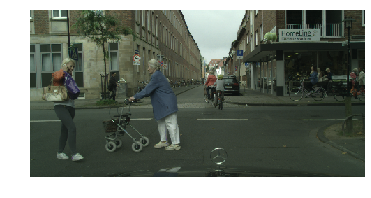

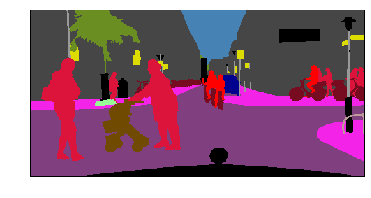

In [32]:
# Get a batch of training data
inputs, targets = next(val_loader)
# inputs, targets = next(iter(test_loader_gta))
# inputs, targets = next(iter(test_loader_gta))

# Plot Single Image
view_image(inputs[0])

inputs1 = Variable(inputs).cuda(device_id=0)
inputs2 = Variable(inputs).cuda(device_id=0)

# Plot Target Image
view_annotated(targets[0])

# Plot Grid of images
# out1 = torchvision.utils.make_grid(inputs, nrow=3)

# view_image(out1)

## Train

* https://github.com/pytorch/examples/blob/master/imagenet/main.py

**Hyperparameters**

* WeightInitialization = HeUniform
* Optimizer = RMSProp
* LR = .001 with exponential decay of 0.995 after each epoch
* Data Augmentation = Random Crops, Vertical Flips
* ValidationSet with early stopping based on IoU or MeanAccuracy with patience of 100 (50 during finetuning)
* WeightDecay = .0001
* Finetune with full-size images, LR = .0001
* Dropout = 0.2
* BatchNorm "we use current batch stats at training, validation, and test time"

In [33]:
def get_predictions(output_batch):
    # Variables(Tensors) of size (bs,12,224,224)
    bs,c,h,w = output_batch.size()
    tensor = output_batch.data
    # Argmax along channel axis (softmax probabilities)
    values, indices = tensor.cpu().max(1)
    indices = indices.view(bs,h,w)
    return indices

def error(preds, targets):
    assert preds.size() == targets.size()
    bs,h,w = preds.size()
    n_pixels = bs*h*w
    incorrect = preds.ne(targets).cpu().sum()
    err = 100.*incorrect/n_pixels
    return round(err,5)
        
def train(model, trn_loader, optimizer, criterion, epoch):
    model.train()
    trn_loss = 0
    trn_error = 0
    for batch_idx, (inputs, targets) in enumerate(trn_loader):
        if batch_idx%100==0:
            print(batch_idx*batch_size,'/',len(train_loader_gta)*batch_size)
        inputs, targets = Variable(inputs.cuda()), Variable(targets.cuda())
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        trn_loss += loss.data[0]
        pred = get_predictions(output)
        trn_error += error(pred, targets.data.cpu()) # why CPU?
    trn_loss /= len(trn_loader) #n_batches
    trn_error /= len(trn_loader)
    return trn_loss, trn_error

def test(model, test_loader, criterion, epoch=1):
    model.eval()
    test_loss = 0
    test_error = 0
    for data, target in test_loader:
        data = Variable(data.cuda(), volatile=True)
        target = Variable(target.cuda())
        output = model(data)
        test_loss += criterion(output, target).data[0]
        pred = get_predictions(output)
        test_error += error(pred, target.data.cpu())
    test_loss /= len(test_loader) #n_batches
    test_error /= len(test_loader)
    return test_loss, test_error

def adjust_learning_rate(lr, decay, optimizer, cur_epoch, n_epochs):
    """Sets the learning rate to the initially 
        configured `lr` decayed by `decay` every `n_epochs`"""
    new_lr = lr * (decay ** (cur_epoch // n_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        #kaiming is first name of author whose last name is 'He' lol
        init.kaiming_uniform(m.weight) 
        m.bias.data.zero_()

## Config

* https://github.com/SimJeg/FC-DenseNet/blob/master/config/FC-DenseNet103.py

In [34]:
seed = 0
LEARNING_RATE = 1e-4
LR_DECAY = 0.995 # Applied each epoch "exponential decay"
DECAY_LR_EVERY_N_EPOCHS = 1
WEIGHT_DECAY = 0.0001
N_EPOCHS = 150 # ~15-16 for GTA should do (USED TO BE 1000)
MAX_PATIENCE = 10

train_file = RESULTS_PATH+EXPERIMENT+'-train.csv'
test_file = RESULTS_PATH+EXPERIMENT+'-test.csv'
existing_weights_fpath=WEIGHTS_PATH+'latest.pth' # best weights (lowest loss)
existing_optimizer_fpath=WEIGHTS_PATH+'latest-optim.pth'
cudnn.benchmark = True

## Experiment

In [35]:
class Experiment():
    def __init__(self, name, root):
        self.name = name
        self.root = os.path.join(root,name)
        self.epoch = 1
        self.best_val_loss = sys.maxsize
        self.best_val_loss_epoch = 1
        self.weights_dir = os.path.join(self.root, 'weights')
        self.history_dir = os.path.join(self.root, 'history')
        self.results_dir = os.path.join(self.root, 'results')
        self.latest_weights = os.path.join(self.weights_dir, 'latest_weights.pth')
        self.latest_optimizer = os.path.join(self.weights_dir, 'latest_optim.pth')
        self.best_weights_path = self.latest_weights
        self.best_optimizer_path = self.latest_optimizer
        self.train_history_fpath = os.path.join(self.history_dir, 'train.csv')
        self.val_history_fpath = os.path.join(self.history_dir, 'val.csv')
        self.test_history_fpath = os.path.join(self.history_dir, 'test.csv')
        self.loss_history = {
            'train': np.array([]),
            'val': np.array([]),
            'test': np.array([]),
            'val_gta': np.array([]),
            'iou': np.array([])
        } 
        self.error_history = {
            'train': np.array([]),
            'val': np.array([]),
            'test': np.array([]),
            'val_gta': np.array([]),
            'iou': np.array([])
        }
#         self.visdom_plots = self.init_visdom_plots()

    def init(self):
        print("Creating new experiment")
        self.init_dirs()
        self.init_history_files()
        
    def resume(self, model, optim, weights_fpath=None, optim_path=None):
        print("Resuming existing experiment")
        if weights_fpath is None:
            weights_fpath = self.latest_weights
        if optim_path is None:
            optim_path = self.latest_optimizer
        
        model, state = self.load_weights(model, weights_fpath)
        optim = self.load_optimizer(optim, optim_path)
        
        self.best_val_loss = state['best_val_loss']
        self.best_val_loss_epoch = state['best_val_loss_epoch']
        self.epoch = state['last_epoch']+1
        self.load_history_from_file('train')
        self.load_history_from_file('val')
        
        return model, optim

    def init_dirs(self):
        os.makedirs(self.weights_dir)
        os.makedirs(self.history_dir)
        os.makedirs(self.results_dir)

    def init_history_files(self):
        Path(self.train_history_fpath).touch()
        Path(self.val_history_fpath).touch()
        Path(self.test_history_fpath).touch()
        
    def init_visdom_plots(self):
        loss = self.init_viz_train_plot('loss')
        error = self.init_viz_train_plot('error')
        summary = self.init_viz_txt_plot('summary')
        return {
            'loss':loss,
            'error':error,
            'summary':summary
        }

    def init_viz_train_plot(self, title):
        return viz.line(
            X=np.array([1]),
            Y=np.array([[1, 1]]),
            opts=dict(
                xlabel='epoch',
                ylabel=title,
                title=self.name+' '+title,
                legend=['Train', 'Validation']
            ),
            env=self.name
        )

    def init_viz_txt_plot(self, title):
        return viz.text(
            "Initializing.. " + title,
            env=self.name
        )    
    
    def viz_epochs(self):
        epochs = np.arange(1,self.epoch+1)
        return np.stack([epochs, epochs],1)
    
    def update_viz_loss_plot(self):
        loss = np.stack([self.loss_history['train'],
                         self.loss_history['val']],1)
        window = self.visdom_plots['loss']
        return viz.line(
            X=self.viz_epochs(),
            Y=loss,
            win=window,
            env=self.name,
            opts=dict(
                xlabel='epoch',
                ylabel='loss',
                title=self.name+' '+'loss',
                legend=['Train', 'Validation']
            ),
        )
    
    def update_viz_error_plot(self):
        error = np.stack([self.error_history['train'],
                         self.error_history['val']], 1)
        window = self.visdom_plots['error']
        return viz.line(
            X=self.viz_epochs(),
            Y=error,
            win=window,
            env=self.name,
            opts=dict(
                xlabel='epoch',
                ylabel='error',
                title=self.name+' '+'error',
                legend=['Train', 'Validation']
            )
        )
    
    def update_viz_summary_plot(self):
        trn_loss = self.loss_history['train'][-1]
        val_loss = self.loss_history['val'][-1]
        trn_err = self.error_history['train'][-1]        
        val_err = self.error_history['val'][-1]
        txt = ("""Epoch: %d
            Train - Loss: %.3f Err: %.3f
            Test - Loss: %.3f Err: %.3f""" % (self.epoch, 
            trn_loss, trn_err, tst_loss, tst_err))
        window = self.visdom_plots['summary']
        return viz.text(
            txt,
            win=window,
            env=self.name
        )

    def load_history_from_file(self, dset_type):
        fpath = os.path.join(self.history_dir, dset_type+'.csv')
        data = np.loadtxt(fpath, delimiter=',').reshape(-1, 3)
        self.loss_history[dset_type] = data[:,1]
        self.error_history[dset_type] = data[:,2]
    
    def append_history_to_file(self, dset_type, loss, error):
        fpath = os.path.join(self.history_dir, dset_type+'.csv')
        with open(fpath, 'a') as f:
            f.write('{},{},{}\n'.format(self.epoch, loss, error))
    
    def save_history(self, dset_type, loss, error):
        self.loss_history[dset_type] = np.append(
            self.loss_history[dset_type], loss)
        self.error_history[dset_type] = np.append(
            self.error_history[dset_type], error)
        self.append_history_to_file(dset_type, loss, error)
        
        if dset_type == 'val' and self.is_best_loss(loss):
            self.best_val_loss = loss
            self.best_val_loss_epoch = self.epoch

    def is_best_loss(self, loss):
        return loss < self.best_val_loss
        
    def save_weights(self, model, trn_loss, val_loss, trn_err, val_err):
        weights_fname = self.name+'-weights-%d-%.3f-%.3f-%.3f-%.3f.pth' % (
            epoch, trn_loss, trn_err, val_loss, val_err)
        weights_fpath = os.path.join(self.weights_dir, weights_fname)
        torch.save({
                'last_epoch': self.epoch,
                'trn_loss': trn_loss,
                'val_loss': val_loss,
                'trn_err': trn_err,
                'val_err': val_err,
                'best_val_loss': self.best_val_loss,
                'best_val_loss_epoch': self.best_val_loss_epoch,
                'experiment': self.name,
                'state_dict': model.state_dict()
            }, weights_fpath )
        shutil.copyfile(weights_fpath, self.latest_weights)
        if self.is_best_loss(val_loss):
            self.best_weights_path = weights_fpath

    def load_weights(self, model, fpath):
        print("loading weights '{}'".format(fpath))
        state = torch.load(fpath)
        model.load_state_dict(state['state_dict'])
        print (state['trn_err'], state['val_loss'], state['val_err'])
        print("loaded weights from experiment %s (last_epoch %d, trn_loss %s, trn_err %s, val_loss %s, val_err %s)" % (
                  self.name, state['last_epoch'], state['trn_loss'],
                    state['trn_err'], state['val_loss'], state['val_err']))
        return model, state

    def save_optimizer(self, optimizer, val_loss):
        optim_fname = self.name+'-optim-%d.pth' % (epoch)
        optim_fpath = os.path.join(self.weights_dir, optim_fname)
        torch.save({
                'last_epoch': self.epoch,
                'experiment': self.name,
                'state_dict': optimizer.state_dict()
            }, optim_fpath )
        shutil.copyfile(optim_fpath, self.latest_optimizer)
        if self.is_best_loss(val_loss):
            self.best_optimizer_path = optim_path

    def load_optimizer(self, optimizer, fpath):
        print("loading optimizer '{}'".format(fpath))
        optim = torch.load(fpath)
        optimizer.load_state_dict(optim['state_dict'])
        print("loaded optimizer from session {}, last_epoch {}"
              .format(optim['experiment'], optim['last_epoch']))
        return optim

## Run

In [36]:
model = FCDenseNet103(n_classes=34+1).cuda()
print('Number of params: {}'.format(
    sum([p.data.nelement() for p in model.parameters()])))
model.apply(weights_init)
optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = nn.NLLLoss2d(weight=camvid.class_weight.cuda()).cuda()

Number of params: 9328259


In [41]:
exp = Experiment('tiramisu_v23', '/workspace/pytorch_tiramisu/')

In [42]:
exp.init()

Creating new experiment


In [43]:
N_EPOCHS = 150
START_EPOCH = exp.epoch
END_EPOCH = START_EPOCH+N_EPOCHS

In [ ]:
tst_loss = 2
tst_err = 99
for epoch in range(START_EPOCH+1, END_EPOCH):

    since = time.time()

    ### Train ###
    trn_loss, trn_err = train(model, train_loader_city, optimizer, criterion, epoch)
    print('Epoch {:d}: Train - Loss: {:.4f}\tErr: {:.4f}'.format(epoch, trn_loss, trn_err))    
    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    ### Test ###
    val_loss, val_err = test(model, val_loader_city, criterion, epoch)    
    print('Val - Loss: {:.4f}, Error: {:.4f}'.format(val_loss, val_err))
#     val_loss_gta, val_err_gta = test(model, val_loader_gta, criterion, epoch)    
#     print('Val - Loss: {:.4f}, Error: {:.4f}'.format(val_loss_gta, val_err_gta))
    time_elapsed = time.time() - since  
    print('Total Time {:.0f}m {:.0f}s\n'.format(
        time_elapsed // 60, time_elapsed % 60))

    
    ### Save Metrics ###
    exp.save_history('train', trn_loss, trn_err)
#     exp.save_history('val_gta', val_loss_gta, val_err_gta)
#     exp.save_history('iou', val_mean_IU_city, val_mean_IU_gta)
    exp.save_history('val', val_loss, val_err)
    
    ### Checkpoint ###    
    exp.save_weights(model, trn_loss, val_loss, trn_err, val_err)
    exp.save_optimizer(optimizer, val_loss)
    
    
    ## Early Stopping ##
    if (epoch - exp.best_val_loss_epoch) > MAX_PATIENCE:
        print(("Early stopping at epoch",epoch, "since no better loss found since epoch",exp.best_val_loss))
        break


    ### Adjust Lr ###
    adjust_learning_rate(LEARNING_RATE, LR_DECAY, optimizer, 
                         epoch, DECAY_LR_EVERY_N_EPOCHS)
    
    exp.epoch += 1

In [47]:
# exp = Experiment('tiramisu12', '/home/bfortuner/workplace/pytorch_tiramisu/')
# exp.resume(model, optimizer)

In [48]:
model_baseline = FCDenseNet103(n_classes=34+1).cuda()
state = torch.load("/workspace/pytorch_tiramisu/tiramisu_city_weights_equal_3/weights/latest_weights.pth")
model_baseline.load_state_dict(state['state_dict'])

model_20p_baseline = FCDenseNet103(n_classes=34+1).cuda()
state = torch.load("/workspace/pytorch_tiramisu/tiramisu_city_smallset/weights/tiramisu_city_smallset-weights-8-1.062-31.338-1.271-37.751.pth")
model_20p_baseline.load_state_dict(state['state_dict'])

model_20p_gta = FCDenseNet103(n_classes=34+1).cuda()
state = torch.load("/workspace/pytorch_tiramisu/tiramisu_city_finetuned_fixed/weights/tiramisu_city_finetuned_fixed-weights-9-0.630-17.752-0.915-25.680.pth")
model_20p_gta.load_state_dict(state['state_dict'])

model_40p_baseline = FCDenseNet103(n_classes=34+1).cuda()
state = torch.load("/workspace/pytorch_tiramisu/tiramisu_pure_city_50p_2/weights/tiramisu_pure_city_50p_2-weights-15-0.899-26.417-0.989-27.809.pth")
model_40p_baseline.load_state_dict(state['state_dict'])

model_40p_gta = FCDenseNet103(n_classes=34+1).cuda()
state = torch.load("/workspace/pytorch_tiramisu/tiramisu_gta_city_50p_2/weights/tiramisu_gta_city_50p_2-weights-23-0.564-16.053-0.687-18.990.pth")
model_40p_gta.load_state_dict(state['state_dict'])

In [49]:
max_label=35

def get_iou(pred,gt):
#     pred = gt.data.cpu()
    if pred.shape!= gt.shape:
        print('pred shape',pred.shape, 'gt shape', gt.shape)
    assert(pred.shape == gt.shape)    
    gt = gt.astype(np.float32)
    pred = pred.astype(np.float32)

    count = np.zeros((max_label+1,))
#     19, 25, 27, 28, 31, 32 
#     lst = [7,8,11,12,13,17,19,20,21,22,23,24,25,26,27,28, 31,32,33]
    lst = [7,8,11,12,13,17,19,20,21,22,23,24,25,26,31,33]

    for j in lst: # range(max_label+1):
        x = np.where(pred==j)
        p_idx_j = set(zip(x[0].tolist(),x[1].tolist()))
        x = np.where(gt==j)
        GT_idx_j = set(zip(x[0].tolist(),x[1].tolist()))
        n_jj = set.intersection(p_idx_j,GT_idx_j)
        u_jj = set.union(p_idx_j,GT_idx_j)
    
        if len(GT_idx_j)!=0:
            count[j] = float(len(n_jj))/float(len(u_jj))

    result_class = count
    Aiou = np.sum(result_class[:])/float(len(lst)) #float(len(np.unique(gt))) 
    
    return Aiou, result_class

In [50]:
m=0
val_mean_IU = 0
class_list = np.array(36*[0.0])
for data, target0 in test_loader_city:
        m+=1
        data = Variable(data.cuda(), volatile=True)
        target = Variable(target0.cuda())
        output = model_40p_gta(data)
        pred = get_predictions(output)
        results_dict, class_array=get_iou(pred.numpy(),target0.numpy()) 
        class_list += class_array
        val_mean_IU +=(results_dict)
class_list = np.array(class_list)
print(val_mean_IU / m)

0.520101589517


In [ ]:
proc = np.round(class_list/500*100,1)
np.set_printoptions(precision=1)
mean = round(np.mean(proc[proc>0]),1)
print(proc[11], "&",proc[21], "&",proc[23], "&",proc[26], "&", proc[20], "&",proc[7], "&",proc[24], "&",proc[13], "&",proc[17], "&",proc[8], "&",proc[33],"&", mean,"& 0", "\\\\" )

In [37]:
criterion = nn.NLLLoss2d(weight=camvid.class_weight.cuda()).cuda()
test(model_40p_gta, test_loader_city, criterion)

(0.6870694160461426, 18.9897206)

## Test

In [93]:
def predict(model, input_loader, n_batches=1):
    input_loader.batch_size = 1
    #Takes input_loader and returns array of prediction tensors
    predictions = []
    model.eval()
    for input, target in input_loader:
        data, label = Variable(input.cuda(), volatile=True), Variable(target.cuda())
        output = model(data)
        pred = get_predictions(output)
        predictions.append([input,target,pred])
    return predictions


def view_sample_predictions(n):
    #torch.cuda.manual_seed(random.randint(0,10**7))
    test_loader = torch.utils.data.DataLoader(test_dset_city, batch_size=n, shuffle=False)
    inputs, targets = next(iter(test_loader))
    data, label = Variable(inputs.cuda(), volatile=True), Variable(targets.cuda())
    output1 = model_baseline(data)
    output2 = model_40p_baseline(data)
    output3 = model_40p_gta(data)
    pred1 = get_predictions(output1)
#     pred2= get_predictions(output2)
#     pred3 = get_predictions(output3)
    batch_size = inputs.size(0)
    for i in range(batch_size):
#         view_image(inputs[i])
#         view_annotated(targets[i])
        view_annotated(pred1[i]) 
#         view_annotated(pred2[i]) 
#         view_annotated(pred3[i]) 

In [52]:
view_sample_predictions(1)

In [125]:
def generate_frames():
    #torch.cuda.manual_seed(random.randint(0,10**7))
    test_loader = torch.utils.data.DataLoader(test_dset_vid, batch_size=5, shuffle=False)
    iterator = iter(test_loader)

    for i in range(498):
        inputs, targets = next(iterator)
        data, label = Variable(inputs.cuda(), volatile=True), Variable(targets.cuda())
        output1 = model_baseline(data)
        pred1 = get_predictions(output1)
        
        for j in range(5):
#             print(5*i+j)
            rgb = view_annotated(pred1[j],plot=False)
            plt.imsave('/workspace/segmentation/data/vid_frame/processed/'+test_dset_vid.imgs[5*i+j][-8:], rgb)
        

In [ ]:
generate_frames()